In [1]:
from dotenv import load_dotenv
import os
import sys
from langchain_openai import ChatOpenAI
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.messages import HumanMessage
from langchain_core.output_parsers import StrOutputParser
from langchain_core.tools import Tool
from langchain_openai import OpenAIEmbeddings
from langchain_community.document_loaders import WebBaseLoader
from langchain_text_splitters import RecursiveCharacterTextSplitter 
from langchain_community.vectorstores import Chroma
from langchain.tools.retriever import create_retriever_tool
from langgraph.prebuilt import ToolNode
from typing import Annotated,Sequence, TypedDict
from langchain_core.messages import BaseMessage
from langgraph.graph.message import add_messages
from langchain_core.prompts import PromptTemplate
from langchain_core.pydantic_v1 import BaseModel, Field
from typing import Literal
from langgraph.graph import END, StateGraph, START
from langgraph.prebuilt import tools_condition

import warnings
warnings.filterwarnings("ignore")

load_dotenv()



USER_AGENT environment variable not set, consider setting it to identify your requests.
/Users/kausik/Desktop/Agentic-AI/venv/lib/python3.12/site-packages/IPython/core/interactiveshell.py:3672: LangChainDeprecationWarning: As of langchain-core 0.3.0, LangChain uses pydantic v2 internally. The langchain_core.pydantic_v1 module was a compatibility shim for pydantic v1, and should no longer be used. Please update the code to import from Pydantic directly.

For example, replace imports like: `from langchain_core.pydantic_v1 import BaseModel`
with: `from pydantic import BaseModel`
or the v1 compatibility namespace if you are working in a code base that has not been fully upgraded to pydantic 2 yet. 	from pydantic.v1 import BaseModel

  exec(code_obj, self.user_global_ns, self.user_ns)


True

In [2]:
llm = ChatOpenAI()
#llm.invoke("hello how are you my firend?")
embeddings = OpenAIEmbeddings(
    model="text-embedding-3-large"
)

#embeddings.embed_query("hello how are you my firend?")
#len(embeddings.embed_query("hello how are you my firend?"))


In [3]:
urls=[
    "https://lilianweng.github.io/posts/2023-06-23-agent/",
    "https://lilianweng.github.io/posts/2023-03-15-prompt-engineering/",
]

docs=[WebBaseLoader(url).load() for url in urls]
docs_list=[item for sublist in docs for item in sublist]
text_splitter=RecursiveCharacterTextSplitter.from_tiktoken_encoder(chunk_size=100,chunk_overlap=25) 
doc_splits=text_splitter.split_documents(docs_list)
print(f"Number of documents: {len(doc_splits)}")

Number of documents: 287


In [4]:
vectorstore=Chroma.from_documents(
    documents=doc_splits,
    collection_name="rag-chrome",
    embedding=embeddings
    
)
retriever=vectorstore.as_retriever()
#retriever.invoke("what is agent and prompt?")

In [5]:
retriever_tool=create_retriever_tool(
    retriever,
    "retriever_blog_post",
    "Search and return information about Lilian Weng blog posts on LLM agents, prompt engineering, and adversarial attacks on LLMs.You are a specialized assistant. Use the 'retriever_tool' **only** when the query explicitly relates to LangChain blog data. For all other queries, respond directly without using any tool. For simple queries like 'hi', 'hello', or 'how are you', provide a normal response.",
    )

tools=[retriever_tool]
retriever_node=ToolNode(tools)

In [6]:
class AgentState(TypedDict):
    messages: Annotated[Sequence[BaseMessage], add_messages]

In [ ]:
# def LLM_Decision_Maker(state:AgentState):
#     print("----CALL LLM_DECISION_MAKE----")
#     message=state["messages"]
    
#     if len(message)>1:
#         last_message=message[-1]
#         question=last_message.content
        
#         prompt=PromptTemplate(
#         template="""You are a helpful assistant whatever question has been asked to find out that in the given question and answer.
#                         Here is the question:{question}
#                         """,
#                         input_variables=["question"]
#                         )
#         chain=prompt | llm
#         response=chain.invoke({"question":question})
#         return {"messages":[response]}
#     else:
#         llm_with_tool=llm.bind_tools(tools)
#         response=llm_with_tool.invoke(message)
#         return {"messages":[response]}

In [ ]:
llm

In [ ]:

tools

In [16]:
llm_with_tool=llm.bind_tools(tools)
response=llm_with_tool.invoke("what is LLM Powered Autonomous Agents explain the planning and reflection and prompt engineering explain me in terms of agents and langchain?")

print("----LLM_WITH_TOOL----")

print(response)

----LLM_WITH_TOOL----
content='' additional_kwargs={'tool_calls': [{'id': 'call_nVHMV2Tpu6CdDcW42g44urIr', 'function': {'arguments': '{"query": "LLM Powered Autonomous Agents"}', 'name': 'retriever_blog_post'}, 'type': 'function'}, {'id': 'call_Wqj6v5F9sg8inHUQxwQt44AI', 'function': {'arguments': '{"query": "planning and reflection in LLM Powered Autonomous Agents"}', 'name': 'retriever_blog_post'}, 'type': 'function'}, {'id': 'call_w2mX8O5JwItPAH6seW2cD4TV', 'function': {'arguments': '{"query": "prompt engineering in LLM Powered Autonomous Agents"}', 'name': 'retriever_blog_post'}, 'type': 'function'}], 'refusal': None} response_metadata={'token_usage': {'completion_tokens': 86, 'prompt_tokens': 163, 'total_tokens': 249, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-3.5-turbo-0125', 'system_fingerprint': None

In [17]:
def LLM_Decision_Maker(state:AgentState):
    print("----CALL LLM_DECISION_MAKE----")
    message=state["messages"]
    last_message=message[-1]
    question=last_message.content
    response=llm_with_tool.invoke(question)
    return {"messages":[response]}

In [8]:
class grade(BaseModel):
    binary_score:str=Field(description="Relvance score 'yes' or 'no'")

In [9]:
def grade_documents(state:AgentState)->Literal["Output Generator", "Query Rewriter"]:
    print("----CALLING GRADE FOR CHECKING RELEVANCY----")
    llm_with_structure_op=llm.with_structured_output(grade)
    
    prompt=PromptTemplate(
        template="""You are a grader deciding if a document is relevant to a user’s question.
                    Here is the document: {context}
                    Here is the user’s question: {question}
                    If the document talks about or contains information related to the user’s question, mark it as relevant. 
                    Give a 'yes' or 'no' answer to show if the document is relevant to the question.""",
                    input_variables=["context", "question"]
                    )
     
    chain=prompt|llm_with_structure_op
     
     
    message=state['messages']
    
    last_message = message[-1]
    
    question = message[0].content
    
    docs = last_message.content
    
    scored_result=chain.invoke({"question": question, "context": docs})
    
    score=scored_result.binary_score
     
    if score=="yes":
        print("----DECISION: DOCS ARE RELEVANT----")
        return "generator"
    else:
        print("----DECISION: DOCS ARE NOT RELEVANT----")
        return "rewriter"

In [10]:
from langchain import hub
hub.pull("rlm/rag-prompt").pretty_print()

================================ Human Message =================================

You are an assistant for question-answering tasks. Use the following pieces of retrieved context to answer the question. If you don't know the answer, just say that you don't know. Use three sentences maximum and keep the answer concise.
Question: {question} 
Context: {context} 
Answer:


In [11]:
def generate(state:AgentState):
    print("----RAG OUTPUT GENERATE----")
    
    message=state["messages"]
    question=message[0].content
    
    last_message = message[-1]
    docs = last_message.content
    
    prompt=hub.pull("rlm/rag-prompt")
    
    rag_chain=prompt | llm
    
    response=rag_chain.invoke({"context": docs, "question": question})
    
    print(f"this is my response:{response}")
    
    return {"messages": [response]}
    

In [12]:
def rewrite(state:AgentState):
    print("----TRANSFORM QUERY----")
    message=state["messages"]
    
    question=message[0].content
    
    input= [HumanMessage(content=f"""Look at the input and try to reason about the underlying semantic intent or meaning. 
                    Here is the initial question: {question} 
                    Formulate an improved question: """)
       ]

    response=llm.invoke(input)
    
    return {"messages": [response]}
    

In [ ]:
workflow=StateGraph(AgentState)


workflow.add_node("LLM Decision Maker",LLM_Decision_Maker)
workflow.add_node("Vector Retriever",retriever_node)
workflow.add_node("Output Generator",generate)
workflow.add_node("Query Rewriter",rewrite)

workflow.add_edge(START,"LLM Decision Maker")
workflow.add_conditional_edges("LLM Decision Maker",
                               tools_condition,
                               {"tools":"Vector Retriever",
                                END:END
                                })
workflow.add_conditional_edges("Vector Retriever",
                               grade_documents,
                               {"generator":"Output Generator",
                                "rewriter":"Query Rewriter"
                                })
workflow.add_edge("Output Generator",END)
workflow.add_edge("Query Rewriter","LLM Decision Maker")

app=workflow.compile()

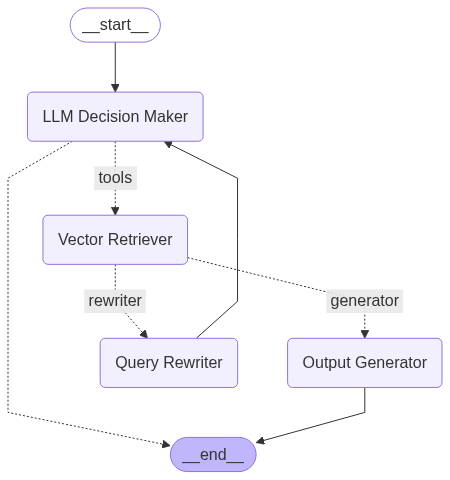

In [19]:
app

In [20]:
app.invoke({"messages":["what is LLM Powered Autonomous Agents explain the planning and reflection and prompt engineering explain me in terms of agents and langchain?"]})

----CALL LLM_DECISION_MAKE----
----CALLING GRADE FOR CHECKING RELEVANCY----
----DECISION: DOCS ARE RELEVANT----
----RAG OUTPUT GENERATE----
this is my response:content='LLM Powered Autonomous Agents utilize reflections from failed trajectories to guide future plan changes. By prompting LM with recent observations and generating high-level questions, agents can translate reflections and environment information into actions. This design combines LLM with memory, planning, and reflection mechanisms for improved agent behavior and interaction.' additional_kwargs={'refusal': None} response_metadata={'token_usage': {'completion_tokens': 58, 'prompt_tokens': 285, 'total_tokens': 343, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-3.5-turbo-0125', 'system_fingerprint': None, 'id': 'chatcmpl-Bl0nk2BDBqiLvQLRi0WqwE35CiD0

{'messages': [HumanMessage(content='what is LLM Powered Autonomous Agents explain the planning and reflection and prompt engineering explain me in terms of agents and langchain?', additional_kwargs={}, response_metadata={}, id='912db302-726b-4b5a-a815-d1a2e0c3a2aa'),
  AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_eXLwpSgOcu6Wu0CBozwHzARS', 'function': {'arguments': '{"query": "LLM Powered Autonomous Agents"}', 'name': 'retriever_blog_post'}, 'type': 'function'}, {'id': 'call_5txEsdLpNC3xzBJgjxv2dh4S', 'function': {'arguments': '{"query": "planning and reflection in LLM"}', 'name': 'retriever_blog_post'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 59, 'prompt_tokens': 163, 'total_tokens': 222, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': '

In [21]:
app.invoke({"messages":["hi how are you gpt?"]})

----CALL LLM_DECISION_MAKE----


{'messages': [HumanMessage(content='hi how are you gpt?', additional_kwargs={}, response_metadata={}, id='dd2b7af5-fce7-4ae8-86cb-d738783e0eb6'),
  AIMessage(content="Hello! I'm here and ready to assist you. How can I help you today?", additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 19, 'prompt_tokens': 145, 'total_tokens': 164, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-3.5-turbo-0125', 'system_fingerprint': None, 'id': 'chatcmpl-Bl0td54kwhRkzEcwu6GkiuNcOVOFR', 'service_tier': 'default', 'finish_reason': 'stop', 'logprobs': None}, id='run--3739f411-63f5-4e69-b516-cf236e09f5eb-0', usage_metadata={'input_tokens': 145, 'output_tokens': 19, 'total_tokens': 164, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}

In [22]:
app.invoke({"messages":["what is a capital of india?"]})

----CALL LLM_DECISION_MAKE----


{'messages': [HumanMessage(content='what is a capital of india?', additional_kwargs={}, response_metadata={}, id='5bc0c504-0f6c-436d-aafb-834a0d4b6ba7'),
  AIMessage(content='The capital of India is New Delhi.', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 9, 'prompt_tokens': 145, 'total_tokens': 154, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-3.5-turbo-0125', 'system_fingerprint': None, 'id': 'chatcmpl-Bl0tnfNChaueO8GzamFnrpxDnXwK7', 'service_tier': 'default', 'finish_reason': 'stop', 'logprobs': None}, id='run--7a7d54fc-76a9-44b2-b47f-82e16321ba8f-0', usage_metadata={'input_tokens': 145, 'output_tokens': 9, 'total_tokens': 154, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}})]}

In [25]:
question="can you explain me what is a task decomposition and why Chain of thought (CoT; Wei et al. 2022) has become a standard prompting technique for enhancing model performance on complex tasks use tool?"
app.invoke({"messages":[question]})

----CALL LLM_DECISION_MAKE----
----CALLING GRADE FOR CHECKING RELEVANCY----
----DECISION: DOCS ARE RELEVANT----
----RAG OUTPUT GENERATE----
this is my response:content="Task decomposition is a technique of breaking down complex tasks into smaller and simpler steps to enhance model performance. Chain of Thought (CoT) is a standard prompting technique that instructs models to think step by step, transforming big tasks into manageable tasks to allow for a deeper interpretation of the model's thinking process. CoT generates short sentences describing reasoning logic in a sequence, known as reasoning chains, which benefits complicated reasoning tasks with large models." additional_kwargs={'refusal': None} response_metadata={'token_usage': {'completion_tokens': 87, 'prompt_tokens': 460, 'total_tokens': 547, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'ca

{'messages': [HumanMessage(content='can you explain me what is a task decomposition and why Chain of thought (CoT; Wei et al. 2022) has become a standard prompting technique for enhancing model performance on complex tasks use tool?', additional_kwargs={}, response_metadata={}, id='e2800ae1-0106-498f-b4c7-5e8807989ae1'),
  AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_9zyvz6V40lyv3Vvd6uh9xylk', 'function': {'arguments': '{"query":"task decomposition and Chain of Thought (CoT; Wei et al. 2022)"}', 'name': 'retriever_blog_post'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 34, 'prompt_tokens': 180, 'total_tokens': 214, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-3.5-turbo-0125', 'system_fingerprint': None, 'id': 'chatcmpl-Bl0x7nF35x2VSf

In [31]:
app.invoke({"messages":["what is 782 * 782 using tool?"]})

----CALL LLM_DECISION_MAKE----
----CALLING GRADE FOR CHECKING RELEVANCY----
----DECISION: DOCS ARE NOT RELEVANT----
----TRANSFORM QUERY----
----CALL LLM_DECISION_MAKE----


{'messages': [HumanMessage(content='what is 782 * 782 using tool?', additional_kwargs={}, response_metadata={}, id='f21e01d2-0a1f-471e-8c52-fd81f9bb861f'),
  AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_Gw2qQ9uTBYncqFtWTeJNxA0A', 'function': {'arguments': '{"query": "What is 782*782?"}', 'name': 'retriever_blog_post'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 38, 'prompt_tokens': 148, 'total_tokens': 186, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-3.5-turbo-0125', 'system_fingerprint': None, 'id': 'chatcmpl-Bl0z9mZXvOdqocEkgwlayWjsfvUaX', 'service_tier': 'default', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--3ee928bb-2e89-4be9-bbf5-22d196372d44-0', tool_calls=[{'name': 'retriever_blog_post', 'args': {'query': 'What

In [59]:
from langchain_core.documents import Document


def tavily_web_search(state):
    """
    Web search based on the re-written question.

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): Updates documents key with appended web results
    """

    print("---WEB SEARCH---")
    from langchain_community.tools.tavily_search import TavilySearchResults

    # Initialize Tavily web search tool
    web_search_tool = TavilySearchResults(k=3)
    
    # Extract question from messages or use the question key if available
    if "question" in state:
        question = state["question"]
        # If question is an AIMessage object, extract its content
        if hasattr(question, 'content'):
            question = question.content
    elif "messages" in state:
        # Get the last message or first message as the question
        messages = state["messages"]
        question = messages[-1] if isinstance(messages, list) else str(messages)
        # If it's an AIMessage object, extract its content
        if hasattr(question, 'content'):
            question = question.content
    else:
        raise ValueError("No question or messages found in state")

    # Ensure question is a string
    question = str(question)
    print(f"Searching for: {question}")

    # Web search
    docs = web_search_tool.invoke({"query": question})
    web_results = "\n".join([d["content"] for d in docs])
    web_results = Document(page_content=web_results)

    return {"documents": [web_results], "question": question}

In [60]:
workflow=StateGraph(AgentState)

workflow.add_node("LLM Decision Maker",LLM_Decision_Maker)
workflow.add_node("Vector Retriever",retriever_node)
workflow.add_node("Output Generator",generate)
workflow.add_node("Query Rewriter",rewrite)
workflow.add_node("Tavily Web Search",tavily_web_search)

workflow.add_edge(START,"LLM Decision Maker")
workflow.add_conditional_edges("LLM Decision Maker",
                               tools_condition,
                               {"tools":"Vector Retriever",
                                END:END
                                })
workflow.add_conditional_edges("Vector Retriever",
                               grade_documents,
                               {"generator":"Output Generator",
                                "rewriter":"Query Rewriter"
                                })
workflow.add_edge("Output Generator",END)
workflow.add_edge("Query Rewriter","Tavily Web Search")
workflow.add_edge("Tavily Web Search","Output Generator")

app2=workflow.compile()

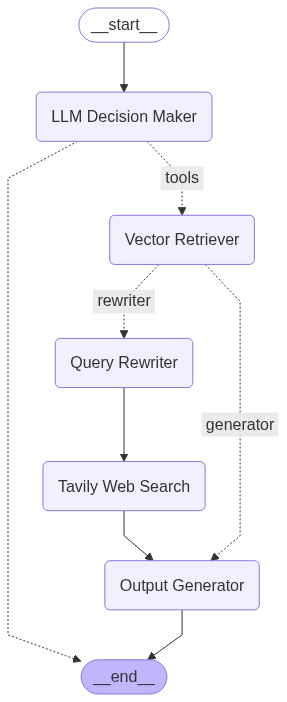

In [57]:
app2

In [49]:
app2.invoke({"messages":["what is 782 * 782 using tool?"]})

----CALL LLM_DECISION_MAKE----
----CALLING GRADE FOR CHECKING RELEVANCY----
----DECISION: DOCS ARE RELEVANT----
----RAG OUTPUT GENERATE----
this is my response:content="I don't know the answer to that question." additional_kwargs={'refusal': None} response_metadata={'token_usage': {'completion_tokens': 10, 'prompt_tokens': 152, 'total_tokens': 162, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-3.5-turbo-0125', 'system_fingerprint': None, 'id': 'chatcmpl-Bl1HQpsXlgJqafXD6rV1fgQGHrYXc', 'service_tier': 'default', 'finish_reason': 'stop', 'logprobs': None} id='run--09461711-553a-46ea-800b-7e909e5b6288-0' usage_metadata={'input_tokens': 152, 'output_tokens': 10, 'total_tokens': 162, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}}


{'messages': [HumanMessage(content='what is 782 * 782 using tool?', additional_kwargs={}, response_metadata={}, id='8bedc1da-2820-4cce-be0c-415f200f90f3'),
  AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_usimjjUxyjQTn83KGpTxolb3', 'function': {'arguments': '{"query":"782 * 782"}', 'name': 'retriever_blog_post'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 20, 'prompt_tokens': 148, 'total_tokens': 168, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-3.5-turbo-0125', 'system_fingerprint': None, 'id': 'chatcmpl-Bl1HO6nuuAVPHhLgAbPq9eKIaJ2rT', 'service_tier': 'default', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--2c03c158-fd7f-4d60-b1a4-a29a76bbc43b-0', tool_calls=[{'name': 'retriever_blog_post', 'args': {'query': '782 * 782'},

In [61]:
question="Waht's the news of Iran war using tool?"
app2.invoke({"messages":[question]})

----CALL LLM_DECISION_MAKE----
----CALLING GRADE FOR CHECKING RELEVANCY----
----DECISION: DOCS ARE NOT RELEVANT----
----TRANSFORM QUERY----
---WEB SEARCH---
Searching for: What tools can be used to stay updated on news related to the Iran war?
----RAG OUTPUT GENERATE----
this is my response:content="Some common tools to stay updated on news related to the Iran war include news websites, social media platforms, and news apps. These resources provide real-time updates and analysis on the latest developments in the conflict. It's important to verify sources and cross-check information to ensure accuracy." additional_kwargs={'refusal': None} response_metadata={'token_usage': {'completion_tokens': 55, 'prompt_tokens': 92, 'total_tokens': 147, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-3.5-turbo-0125', 'system_fi

{'messages': [HumanMessage(content="Waht's the news of Iran war using tool?", additional_kwargs={}, response_metadata={}, id='e5613da7-c387-4850-9f9f-ab6cca8b870e'),
  AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_QOt7CYHTaWPbur20OcZ2or2p', 'function': {'arguments': '{"query":"Iran war news"}', 'name': 'retriever_blog_post'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 19, 'prompt_tokens': 149, 'total_tokens': 168, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-3.5-turbo-0125', 'system_fingerprint': None, 'id': 'chatcmpl-Bl1M89AKQouQ0RRxPUleDIt091fDQ', 'service_tier': 'default', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--89b87ce9-8672-471e-8a43-69ce84ed6a90-0', tool_calls=[{'name': 'retriever_blog_post', 'args': {'query':